**Table of contents**<a id='toc0_'></a>    
- [100 Transforming pedestrian data from sensor to robot frame](#toc1_)    
    - [Read camera parameters from config file](#toc1_1_1_)    
  - [Reading data](#toc1_2_)    
  - [Data preprocessing](#toc1_3_)    
    - [Separating object IDs](#toc1_3_1_)    
    - [Data cleaning](#toc1_3_2_)    
    - [Coordinate transformation](#toc1_3_3_)    
  - [Testing](#toc1_4_)    
  - [Deleting raw data columns](#toc1_5_)    
  - [Save data set](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[100 Transforming pedestrian data from sensor to robot frame](#toc0_)

This notebooks transforms pedestrian data from the sensor frame to the robot frame.

In [29]:
load_from_config = True
raw_data_folder = ""
preprocessed_data_folder = ""

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import yaml
import os
import sys

sys.path.insert(0, os.path.abspath('../src'))
from camera_parameter import CameraParameter

In [31]:
with open('../config.yaml') as file:
  params= yaml.safe_load(file)

In [32]:
# in case of a automatic run
if not load_from_config:
    params['raw_data_folder'] = raw_data_folder
    params['preprocessed_data_folder'] = preprocessed_data_folder

### <a id='toc1_1_1_'></a>[Read camera parameters from config file](#toc0_)

In [33]:
zeds={}
for camera in params['zed_parameter']['cameras']:
    zeds[camera['frame']] = CameraParameter(**camera)

zeds['left']


Camera 'left'
delta_x=-0.28, delta_y=0, delta_angle=90
offset=20000 
local_camera_max_angle=168.629909, local_camera_min_angle=2.663306

## <a id='toc1_2_'></a>[Reading data](#toc0_)

In [34]:
df = pd.DataFrame()

file_names = ['front.csv', 'rear.csv', 'left.csv', 'right.csv']
folder_name = params['data_folder']+params['raw_data_folder']

lst = []
for file_name in file_names:
    print(file_name)
    data = pd.read_csv(folder_name + file_name)
    data['obj.frame'] = file_name.split('.')[0]
    lst.append(data)

df = pd.concat(lst)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df['obj.frame'].value_counts()

front.csv
rear.csv
left.csv
right.csv


obj.frame
front    14424
right     8586
left       568
rear        33
Name: count, dtype: int64

In [35]:
relevant_columns = df.columns[df.columns.str.contains('|'.join(['obj', 'gnss']))]
df_humans = df[relevant_columns]

## <a id='toc1_3_'></a>[Data preprocessing](#toc0_)

### <a id='toc1_3_1_'></a>[Separating object IDs](#toc0_)

In [36]:
# Map frame specific offset to 'label_id' to distinguish between different cameras

mapping = {}
for zed in zeds:
    mapping[zed]=zeds[zed].offset

print(mapping)

df_humans['obj.label_id_unique'] = df_humans['obj.frame'].map(mapping)
df_humans['obj.label_id_unique'] = df_humans['obj.label_id'] + df_humans['obj.label_id_unique']
df_humans[['obj.label_id', 'obj.frame', 'obj.label_id_unique']].sample(5)

{'front': 10000, 'rear': 40000, 'left': 20000, 'right': 30000}


/tmp/ipykernel_129230/4217295911.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_humans['obj.label_id_unique'] = df_humans['obj.frame'].map(mapping)
/tmp/ipykernel_129230/4217295911.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_humans['obj.label_id_unique'] = df_humans['obj.label_id'] + df_humans['obj.label_id_unique']


,obj.label_id,obj.frame,obj.label_id_unique
5757,977,right,30977
1977,266,front,10266
2020,268,front,10268
351,19,front,10019
7163,1103,right,31103


In [37]:
df_humans.groupby(['obj.frame'])['obj.label_id_unique'].nunique()

obj.frame
front    265
left       2
rear       1
right    174
Name: obj.label_id_unique, dtype: int64

### <a id='toc1_3_2_'></a>[Data cleaning](#toc0_)

In [38]:
# How many position information are dubious? Filtering out those with negative y position

print(df_humans[df_humans['obj.position.0'] < 0].shape)

df_humans = df_humans[df_humans['obj.position.0'] > 0]

(53, 41)


In [39]:
# How many objects did not come closer than 10 meters to the camera?

print(df_humans.groupby('obj.label_id_unique')['obj.position.0'].min().loc[lambda x : x > 10].shape)

df_humans = df_humans[df_humans['obj.label_id_unique'].\
                      isin(
                          df_humans.groupby('obj.label_id_unique')['obj.position.0'].min().loc[lambda x : x < 10].index
                          )]

(12,)


In [40]:
df_humans['obj.timestamp'] = pd.to_datetime(df_humans['obj.time'], unit='s')
df_humans['gnss.timestamp'] = pd.to_datetime(df_humans['gnss.time'], unit='s')

### <a id='toc1_3_3_'></a>[Coordinate transformation](#toc0_)

In [41]:
df_humans[['obj.position.0', 'obj.position.1']].describe().loc[['min', 'max']]

,obj.position.0,obj.position.1
min,0.042544,-9.104050
max,10.580249,9.326365


Assumed orientation of the coordinate system

```ascii

         obj.position.0
                 ^            ^ y
                 |            |
                 |            |
                 |            |
                 |            |            x
    x------------x            +------------>  
     obj.position.1                                  
```

https://www.stereolabs.com/docs/positional-tracking/coordinate-frames

In [42]:
df_humans['obj.human_pos.x_sensor'] = -df_humans['obj.position.1']
df_humans['obj.human_pos.y_sensor'] = df_humans['obj.position.0']

In [43]:
# Transform camera coordinates to robot coordinates

def transform_coordinates(x, y, angle, delta_x, delta_y):
    angle = math.radians(angle)
    x_new = x * math.cos(angle) - y * math.sin(angle)
    y_new = x * math.sin(angle) + y * math.cos(angle)
    x_new += delta_x
    y_new += delta_y
    return x_new, y_new

In [44]:
# transform the coordinates of humans depending to the camera position

df_humans['obj.human_pos.x_robot'] = df_humans.apply(lambda row: transform_coordinates(row['obj.human_pos.x_sensor'], 
                                                                    row['obj.human_pos.y_sensor'],
                                                                    zeds[row['obj.frame']].delta_angle,
                                                                    zeds[row['obj.frame']].delta_x,
                                                                    zeds[row['obj.frame']].delta_y)[0], axis=1)

df_humans['obj.human_pos.y_robot'] = df_humans.apply(lambda row: transform_coordinates(row['obj.human_pos.x_sensor'], 
                                                                    row['obj.human_pos.y_sensor'],
                                                                    zeds[row['obj.frame']].delta_angle,
                                                                    zeds[row['obj.frame']].delta_x,
                                                                    zeds[row['obj.frame']].delta_y)[1], axis=1)

In [45]:
# Calculate the RELATIVE speed of the humans
df_humans['obj.human_speed'] = np.sqrt(df_humans['obj.velocity.0']**2 + df_humans['obj.velocity.1']**2)

<Axes: ylabel='Frequency'>

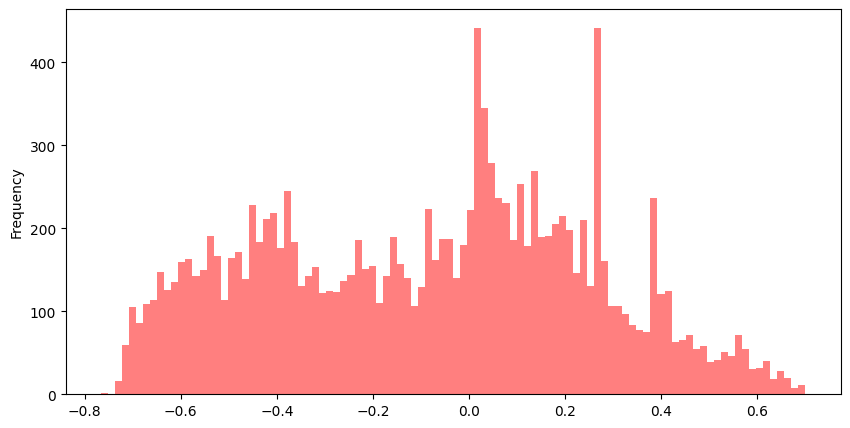

In [46]:
# Determine distance of humans to the robot
df_humans['distance_robot'] = np.sqrt(df_humans['obj.human_pos.x_robot']**2 + df_humans['obj.human_pos.y_robot']**2)

# Determine angle of humans to the robot
df_humans['angle_robot'] = np.arctan2(df_humans['obj.human_pos.x_robot'], df_humans['obj.human_pos.y_robot'])

df_humans[df_humans['obj.frame']=="front"]['angle_robot'].plot.hist(bins=100, alpha=0.5, color='r', label='angle_robot', figsize=(10, 5))


## <a id='toc1_4_'></a>[Testing](#toc0_)

In [47]:
df_humans["obj.frame"].value_counts()

obj.frame
front    14088
right     8541
left       568
rear        23
Name: count, dtype: int64

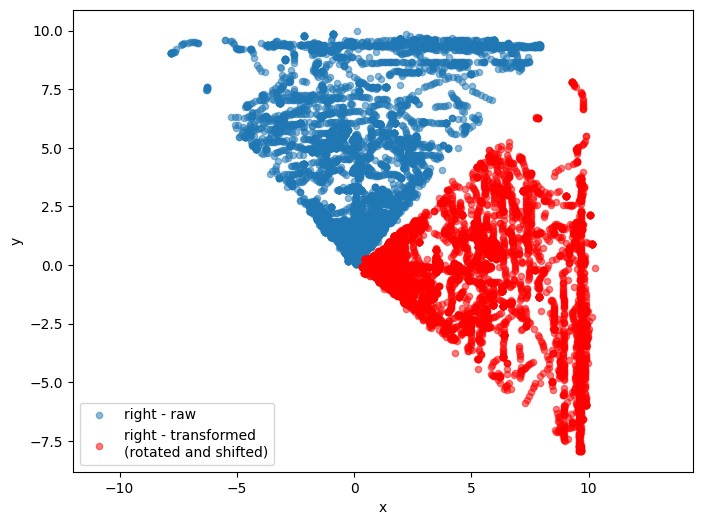

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))

df_humans[df_humans['obj.frame']=="right"].plot.scatter(x='obj.human_pos.x_sensor', y='obj.human_pos.y_sensor', 
                alpha=0.5, ax = ax,
                xlabel='x', ylabel='y', label='right - raw')

df_humans[df_humans['obj.frame']=="right"].plot.scatter(x='obj.human_pos.x_robot', y='obj.human_pos.y_robot', 
                alpha=0.5, ax = ax, c='red',
                xlabel='x', ylabel='y', label='right - transformed\n(rotated and shifted)')

ax.legend();
ax.axis('equal');

In [49]:
df_humans = df_humans[df_humans['obj.frame'] != 'rear']

## <a id='toc1_5_'></a>[Deleting raw data columns](#toc0_)

In [50]:
df_humans.drop(['obj.head_position.0', 'obj.head_position.1', 'obj.head_position.2', 
                'obj.position.0', 'obj.position.1', 'obj.position.2',
                'obj.dimensions_3d.0', 'obj.dimensions_3d.1', 'obj.dimensions_3d.2',
                'obj.label_id', 'gnss.altitude',
                'obj.sublabel', 'gnss.position_covariance.0.',
                'gnss.position_covariance.1.', 'gnss.position_covariance.2.',
                'gnss.position_covariance.3.', 'gnss.position_covariance.4.',
                'gnss.position_covariance.5.', 'gnss.position_covariance.6.',
                'gnss.position_covariance.7.', 'gnss.position_covariance.8.',
                'gnss.position_covariance_type',], axis=1, inplace=True)

In [51]:
df_humans.reset_index(drop=True, inplace=True)

In [52]:
df_humans.head(1).T

,0
obj.time,1684917389.472622
obj.confidence,90.731003
obj.label,Person
obj.position_covariance.0,0.000005
obj.position_covariance.1,0.000004
obj.position_covariance.2,0.0
obj.position_covariance.3,0.000003
obj.position_covariance.4,0.0
obj.position_covariance.5,0.000001
obj.tracking_state,1


## <a id='toc1_6_'></a>[Save data set](#toc0_)

In [53]:
preprocessed_data_folder = params['data_folder'] + params['preprocessed_data_folder']
if not os.path.exists(preprocessed_data_folder):
    os.makedirs(preprocessed_data_folder)

pd.to_pickle(df_humans, preprocessed_data_folder + params['preprocessed_file_labels']+ "humans.pkl")